In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import traceback
import re
import string
import pandas.core.algorithms as algos
from pandas import Series
import os
import datetime as dt
import matplotlib as matplot
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil import relativedelta
#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
#!pip install seaborn
#!conda install -c anaconda seaborn=0.9.0

In [413]:
### Desde nuestro github público consumimos el archivo csv originas
df=pd.read_csv('https://raw.githubusercontent.com/poncho6296/Modelo_Hackathon/main/data/ubicaciones.csv')

In [414]:
df['Multiple']=np.where(df['Frecuencia']==1, 0, 1)

In [415]:
df.head()

Id_Cliente id_Agencia  Frecuencia  Vol_Entrega        lat        lon  \
0           1         A1           1          2.0  20.506052 -98.212377   
1           2         A1           1         17.0  20.458128 -98.221248   
2           3         A1           1          2.0  20.530427 -98.236860   
3           4         A1           3         15.0  20.488655 -98.202940   
4           5         A1           1          2.0  20.533253 -98.219669   

   Multiple  
0         0  
1         0  
2         0  
3         1  
4         0

In [416]:
X=df[['lat','lon']].values

In [417]:
def initialize_centroids(points, k):
    """returns k centroids from the initial points"""
    centroids = points.copy()
    np.random.shuffle(centroids)
    return centroids[:k]

In [418]:
initial=initialize_centroids(X, 6)
initial

array([[ 20.471395, -98.220382],
       [ 20.53056 , -98.174447],
       [ 20.504504, -98.233748],
       [ 20.438249, -98.159356],
       [ 20.482415, -98.170642],
       [ 20.49743 , -98.145606]])

In [419]:
f=df['Frecuencia'].values

In [420]:
def estep(X:np.ndarray,centroid:np.ndarray,frecuencia=0):
    """E-step: Assigns each datapoint to the gaussian component with the
    closest mean

    Args:
        X: (n, d) array holding the data
        mixture: the current gaussian mixture

    Returns:
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples

        """
    n,_=X.shape
    K,_= centroid.shape
    post = np.zeros((n, K))
    

    for i in range(n):
        freq=frecuencia[i]
        tiled_vector = np.tile(X[i, :], (K, 1))
        sse = ((tiled_vector - centroid)**2).sum(axis=1)
        if freq==1:
            j = np.argmin(sse)
            post[i, j] = 1
        else:
            for k in range (freq):
                j=np.argmin(sse)
                post[i,j]=1
                sse[j]=1e6

    return post



In [421]:
post=estep(X,initial,f)
post[3]

array([1., 0., 1., 0., 1., 0.])

In [422]:
def mstep(X: np.ndarray, post: np.ndarray):
    """M-step: Updates the gaussian mixture. Each cluster
    yields a component mean and variance.

    Args: X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples

    Returns:
        GaussianMixture: the new gaussian mixture
        float: the distortion cost for the current assignment
    """
    n, d = X.shape
    _, K = post.shape
    

    n_hat = post.sum(axis=0)
    p = n_hat / n

    cost = 0
    centroid = np.zeros((K, d))
    
    for j in range(K):
        centroid[j, :] = post[:, j] @X / n_hat[j]
        sse = ((centroid[j] - X)**2).sum(axis=1) @ post[:, j]
        cost += sse
    return centroid, cost

In [423]:
mstep(X,post)

(array([[ 20.47121878, -98.23608404],
        [ 20.54407284, -98.16644112],
        [ 20.5084252 , -98.23935267],
        [ 20.45313596, -98.16135414],
        [ 20.48133753, -98.1750503 ],
        [ 20.50394359, -98.14269183]]),
 3.465038574461319)

In [424]:
def run(X=0, centroid=0,frecuencia=0):
    """Runs the mixture model

    Args:
        X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples

    Returns:
        GaussianMixture: the new gaussian mixture
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: distortion cost of the current assignment
    """

    prev_cost = None
    cost = None
    while (prev_cost is None or prev_cost - cost > 1e-10):
        prev_cost = cost
        post = estep(X, centroid,frecuencia)
        centroid, cost = mstep(X, post)

    return centroid, post, cost

In [425]:
centroid,post,cost=run(X,initial,f)

In [426]:
df['Cluster']=np.argmax(post,axis=1)

In [427]:
import matplotlib.cm as cm
import matplotlib.colors as colors
map_Zonas = folium.Map(location=[20.506052, -98.212377], zoom_start=12)
markers_colors = []
i=0
x = np.arange(6)
ys = [i + x + (i*x)**2 for i in range(6)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
for lat, lon, cluster in zip(df['lat'], df['lon'],df['Cluster']):
    
    #i=i+1
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_Zonas)
    #if i==6:
        #break
map_Zonas

In [428]:
df[['Cluster','Vol_Entrega']].groupby(['Cluster']).sum()

Vol_Entrega
Cluster             
0        9102.166667
1        8868.500000
2        7186.000000
3        9050.833333
4        8348.000000
5        5279.000000

In [429]:
df[['Cluster','Vol_Entrega']].groupby(['Cluster']).count()

Vol_Entrega
Cluster             
0                639
1                735
2                628
3                651
4                525
5                447

In [430]:
df['Cluster']=np.argmax(post,axis=1)

In [431]:
df['Cluster_1']=post[:,0]
df['Cluster_2']=post[:,1]
df['Cluster_3']=post[:,2]
df['Cluster_4']=post[:,3]
df['Cluster_5']=post[:,4]
df['Cluster_6']=post[:,5]

In [432]:
df.head()

Id_Cliente id_Agencia  Frecuencia  Vol_Entrega        lat        lon  \
0           1         A1           1          2.0  20.506052 -98.212377   
1           2         A1           1         17.0  20.458128 -98.221248   
2           3         A1           1          2.0  20.530427 -98.236860   
3           4         A1           3         15.0  20.488655 -98.202940   
4           5         A1           1          2.0  20.533253 -98.219669   

   Multiple  Cluster  Cluster_1  Cluster_2  Cluster_3  Cluster_4  Cluster_5  \
0         0        4        0.0        0.0        0.0        0.0        1.0   
1         0        4        0.0        0.0        0.0        0.0        1.0   
2         0        2        0.0        0.0        1.0        0.0        0.0   
3         1        2        0.0        0.0        1.0        1.0        1.0   
4         0        2        0.0        0.0        1.0        0.0        0.0   

   Cluster_6  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0

In [433]:
Zonas=df.melt(id_vars=['Id_Cliente', 'id_Agencia', 'Frecuencia', 'Vol_Entrega', 'lat', 'lon',
       'Multiple', 'Cluster'], 
        var_name="Agrupación", 
        value_name="Value")
Zonas=Zonas[Zonas['Value']!=0]
Zonas[['Agrupación','Vol_Entrega']].groupby(['Agrupación']).sum()

Vol_Entrega
Agrupación              
Cluster_1    9102.166667
Cluster_2    8868.500000
Cluster_3    7500.500000
Cluster_4    9091.500000
Cluster_5   12093.000000
Cluster_6    7744.333333

In [435]:
Zonas[['Agrupación','Vol_Entrega']].groupby(['Agrupación']).count()

Vol_Entrega
Agrupación             
Cluster_1           639
Cluster_2           735
Cluster_3           655
Cluster_4           654
Cluster_5           718
Cluster_6           576

In [436]:
X=df[['lat','lon','Vol_Entrega']]
X['Vol_Entrega']=X['Vol_Entrega']/np.max(df['Vol_Entrega'])
X=X.values
initial=initialize_centroids(X, 6)
centroid,post,cost=run(X,initial,f)
df['Cluster']=np.argmax(post,axis=1)
map_Zonas = folium.Map(location=[20.506052, -98.212377], zoom_start=12)
markers_colors = []
i=0
x = np.arange(6)
ys = [i + x + (i*x)**2 for i in range(6)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
for lat, lon, cluster in zip(df['lat'], df['lon'],df['Cluster']):
    
    #i=i+1
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_Zonas)
    #if i==6:
        #break
map_Zonas

<ipython-input-436-dceeaeb74375>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Vol_Entrega']=X['Vol_Entrega']/np.max(df['Vol_Entrega'])


In [440]:
df['Cluster_1']=post[:,0]
df['Cluster_2']=post[:,1]
df['Cluster_3']=post[:,2]
df['Cluster_4']=post[:,3]
df['Cluster_5']=post[:,4]
df['Cluster_6']=post[:,5]
Zonas=df.melt(id_vars=['Id_Cliente', 'id_Agencia', 'Frecuencia', 'Vol_Entrega', 'lat', 'lon',
       'Multiple', 'Cluster'], 
        var_name="Agrupación", 
        value_name="Value")
Zonas=Zonas[Zonas['Value']!=0]
print(Zonas[['Agrupación','Vol_Entrega']].groupby(['Agrupación']).sum())
print(Zonas[['Agrupación','Vol_Entrega']].groupby(['Agrupación']).count())

             Vol_Entrega
Agrupación              
Cluster_1   11428.500000
Cluster_2    7664.000000
Cluster_3    9346.000000
Cluster_4    5918.333333
Cluster_5   14592.166667
Cluster_6    5451.000000
            Vol_Entrega
Agrupación             
Cluster_1           215
Cluster_2          1002
Cluster_3            88
Cluster_4          1151
Cluster_5           575
Cluster_6           946


In [254]:
from scipy.cluster.vq import vq, kmeans2, whiten
import matplotlib.pyplot as plt
centroid,label=kmeans2(X,6)
df['Cluster']=label

In [257]:
map_Zonas = folium.Map(location=[20.506052, -98.212377], zoom_start=12)
markers_colors = []
i=0
x = np.arange(6)
ys = [i + x + (i*x)**2 for i in range(6)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
for lat, lon, cluster in zip(df['lat'], df['lon'],df['Cluster']):
    
    #i=i+1
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_Zonas)
    #if i==6:
        #break
map_Zonas

In [361]:
!pip install balanced-kmeans

  Created wheel for balanced-kmeans: filename=balanced_kmeans-0.1.0-py3-none-any.whl size=5172 sha256=cf17b97c3771be0c365de374a3a5e29cbdc7439bd02cac3d4c0b700abf13fa6f
  Stored in directory: c:\users\jose juarez\appdata\local\pip\cache\wheels\21\f0\a8\74a325b8bc9b1192975f913da036cf84855d7688124f6d1bab
Successfully built balanced-kmeans


In [368]:
import torch
from balanced_kmeans import kmeans_equal
N,_ = X.shape
batch_size = 10
num_clusters = 6
device = 'cuda'

cluster_size = N // num_clusters
choices, centers = kmeans_equal(X, num_clusters=num_clusters,cluster_size=cluster_size)

AttributeError: 'numpy.ndarray' object has no attribute 'device'

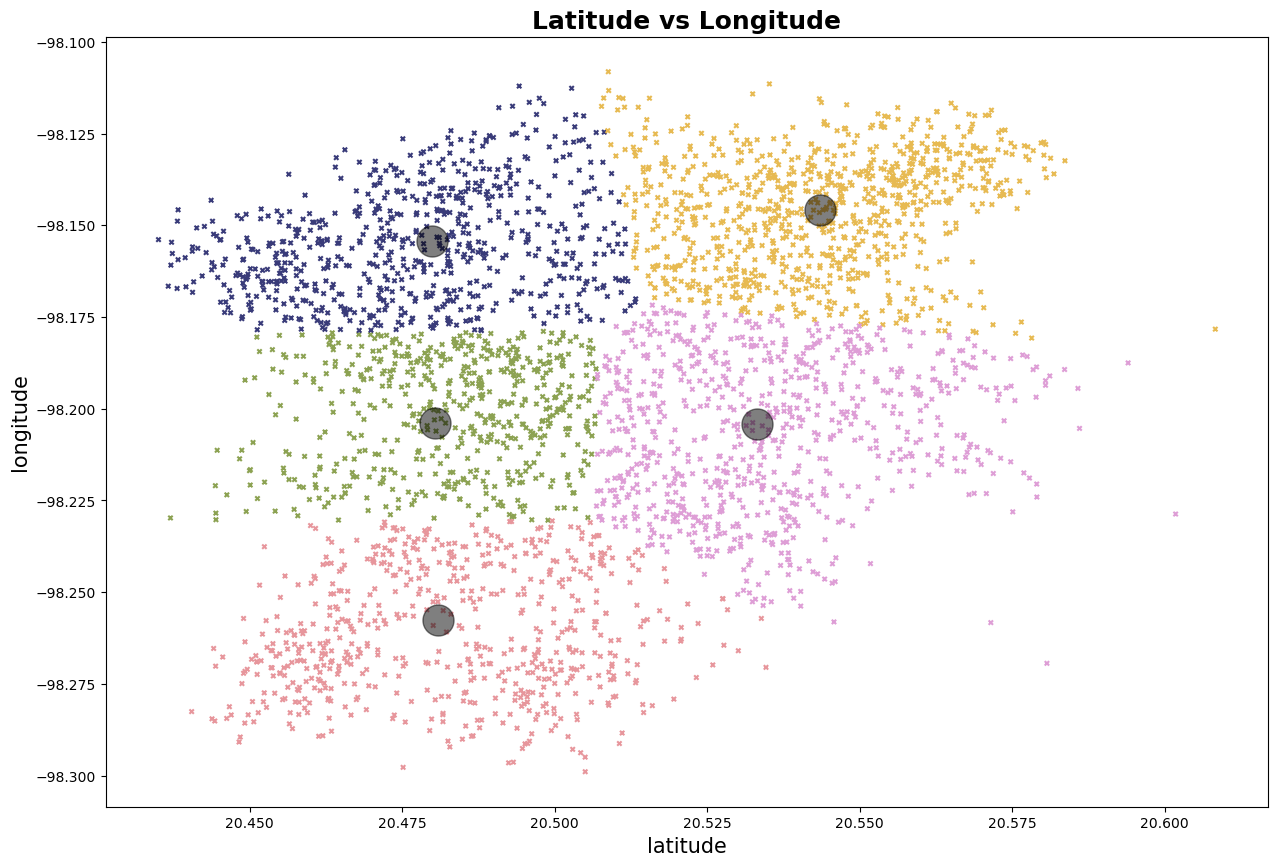

In [379]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0, max_iter=1000)
X=df[['lat','lon']].values
Y=df['Vol_Entrega']*df['Frecuencia'].values
wt_kmeansclus = kmeans.fit(X,sample_weight = Y)
predicted_kmeans = kmeans.predict(X, sample_weight = Y)
plt.style.use('default')
plt.figure(figsize=(15, 10))
plt.scatter(X[:,0], X[:,1], c=wt_kmeansclus.labels_.astype(float),s=10,cmap='tab20b',marker='x')
plt.title('Latitude vs Longitude',fontsize=18, fontweight='bold')
plt.xlabel('latitude',fontsize=15)
plt.ylabel('longitude',fontsize=15)
centers = wt_kmeansclus.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=500, alpha=0.5);

In [380]:
df2=df
df2['Cluster']=predicted_kmeans
df2[['Cluster','Vol_Entrega']].groupby(['Cluster']).sum()

Vol_Entrega
Cluster              
0         9672.833333
1         9612.000000
2        10798.666667
3         8675.166667
4         9075.833333

In [381]:
df2[['Cluster','Vol_Entrega']].groupby(['Cluster']).count()

Vol_Entrega
Cluster             
0                705
1                565
2                924
3                630
4                801

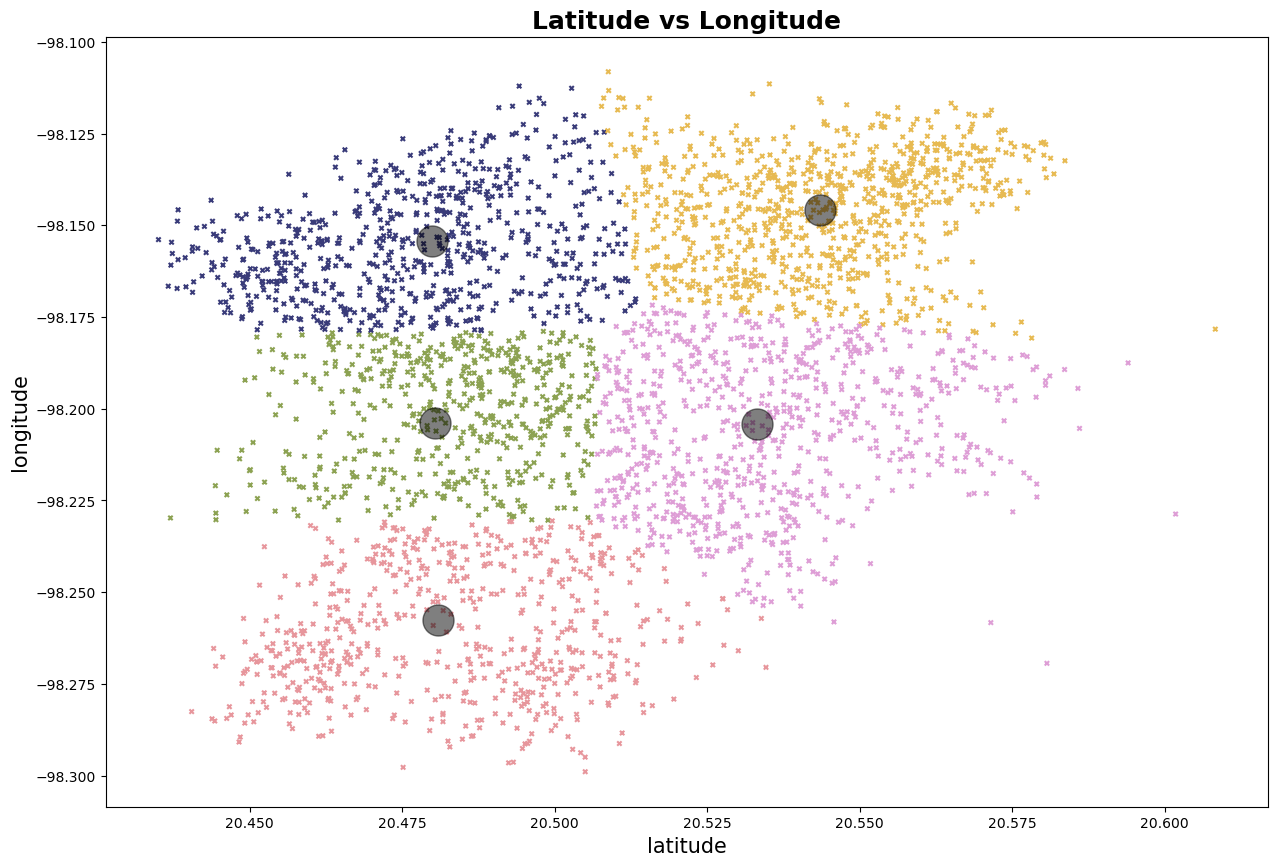

In [384]:
kmeans = KMeans(n_clusters=5, random_state=0, max_iter=1000)
X=df[['lat','lon']].values
df['Vol_total']=df['Vol_Entrega']*df['Frecuencia']
Y=df['Vol_total'].values
wt_kmeansclus = kmeans.fit(X,sample_weight = Y)
predicted_kmeans = kmeans.predict(X, sample_weight = Y)
plt.style.use('default')
plt.figure(figsize=(15, 10))
plt.scatter(X[:,0], X[:,1], c=wt_kmeansclus.labels_.astype(float),s=10,cmap='tab20b',marker='x')
plt.title('Latitude vs Longitude',fontsize=18, fontweight='bold')
plt.xlabel('latitude',fontsize=15)
plt.ylabel('longitude',fontsize=15)
centers = wt_kmeansclus.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=500, alpha=0.5);

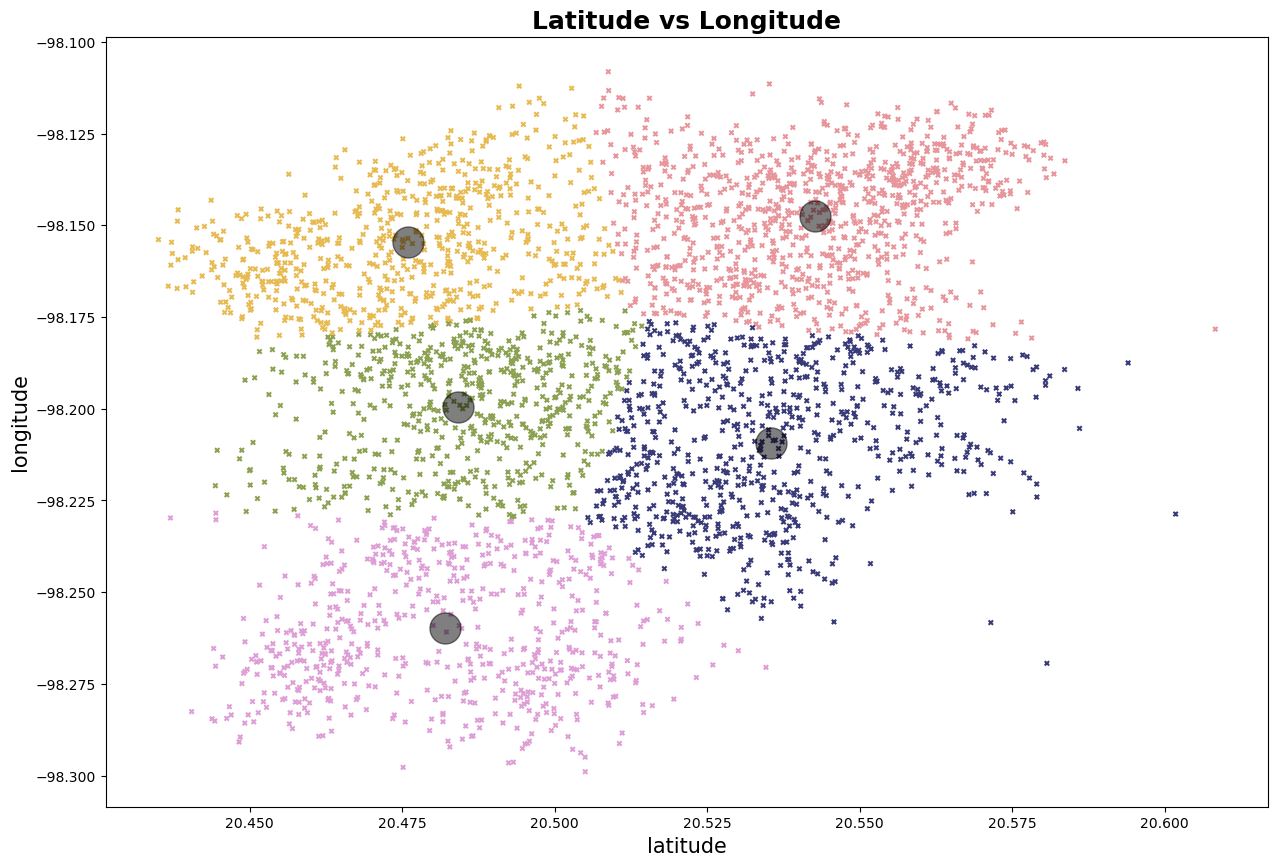

In [385]:
kmeans = KMeans(n_clusters=5, random_state=0, max_iter=1000)
X=df[['lat','lon']].values
df['Vol_total']=df['Vol_Entrega']*df['Frecuencia']
Y=df['Frecuencia'].values
wt_kmeansclus = kmeans.fit(X,sample_weight = Y)
predicted_kmeans = kmeans.predict(X, sample_weight = Y)
plt.style.use('default')
plt.figure(figsize=(15, 10))
plt.scatter(X[:,0], X[:,1], c=wt_kmeansclus.labels_.astype(float),s=10,cmap='tab20b',marker='x')
plt.title('Latitude vs Longitude',fontsize=18, fontweight='bold')
plt.xlabel('latitude',fontsize=15)
plt.ylabel('longitude',fontsize=15)
centers = wt_kmeansclus.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=500, alpha=0.5);

In [386]:
df2['Cluster']=predicted_kmeans
df2[['Cluster','Vol_Entrega']].groupby(['Cluster']).sum()

Vol_Entrega
Cluster              
0         8286.333333
1        10062.333333
2         9123.000000
3        11484.166667
4         8878.666667

In [387]:
df2[['Cluster','Vol_Entrega']].groupby(['Cluster']).count()

Vol_Entrega
Cluster             
0                735
1                610
2                669
3                982
4                629